# Image classification using CNN
### Coded by: Abhinav Gupta, 20171059

We train a convolutional neural network with 3 layers depth for classifying images from the VOC dataset. We train the CNN with different loss functions and compare the results. We also experiment with different combinations of convolution, batch norm, pooling and activation layers. We try varying the learning rates and the weight decay hyperparameters as well. 

'Nuff talking, let's begin! Let's first import the libraries we need. We are going to use PyTorch, because it's the best ML library and a gazillion times better than tensorflow. 

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

- Let's train a CNN to classify images from the **CIFAR-10 dataset**. The images in this dataset belong to 10 classes, namely: {airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck}. 
- First, we load the data. CIFAR-10 is already present in torchvision woohoo! 

In [13]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

- num_workers denotes the number of subprocesses to use for data loading.
- batch_size denotes the number of samples per batch to load.
- We are going to splot the dataset into train and validation sets. valid_size denotes the percentage of training set to be used as validation. 

In [3]:
num_workers = 0
batch_size = 20
valid_size = 0.2

- We convert data to a normalized torch.FloatTensor

In [4]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize( (0.5, 0.5, 0.5), (0.5, 0.5, 0.5) )
                               ])

In [5]:
# choose the training and test datasets
train_data = datasets.CIFAR10('data', train=True,
                              download=True, transform=transform)
test_data = datasets.CIFAR10('data', train=False,
                             download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


- Now, we need to obtain the training indices that will be used for validation. 
- We then compute the split point between the training and validation set. 
- `train_idx` contains the training image indices, `valid idx` contains the validation set image indices.

In [6]:
num_train = len(train_data) # number of training images
indices = list(range(num_train)) # array of image indices
np.random.shuffle(indices)

split = int(np.floor(valid_size * num_train))
print("number of images in validation set: ", split)
train_idx, valid_idx = indices[split:], indices[:split]

number of images in validation set:  10000


- We prepare data loaders by combining dataset and samplers. 

In [7]:
# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                           sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
                                          num_workers=num_workers)

# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

In [8]:
# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

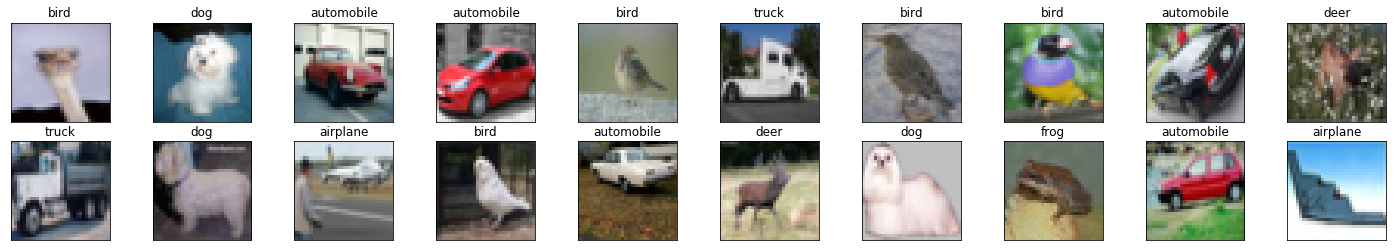

In [9]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

In [11]:
# define the CNN architecture
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        # convolutional layer (sees 32x32x3 image tensor)
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        # convolutional layer (sees 16x16x16 tensor)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        # convolutional layer (sees 8x8x32 tensor)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # linear layer (64 * 4 * 4 -> 500)
        self.fc1 = nn.Linear(64 * 4 * 4, 500)
        # linear layer (500 -> 10)
        self.fc2 = nn.Linear(500, 10)
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        # flatten image input
        x = x.view(-1, 64 * 4 * 4)
        # add dropout layer
        x = self.dropout(x)
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        x = self.fc2(x)
        return x

In [12]:
# create a complete CNN
model = Net()
print(model)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


In [14]:
# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [15]:
# number of epochs to train the model
n_epochs = 15

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    # train the model 
    model.train()
    for data, target in train_loader:
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
           
    # validate the model 
    model.eval()
    for data, target in valid_loader:
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 2.147235 	Validation Loss: 1.896252
Validation loss decreased (inf --> 1.896252).  Saving model ...
Epoch: 2 	Training Loss: 1.696560 	Validation Loss: 1.512819
Validation loss decreased (1.896252 --> 1.512819).  Saving model ...
Epoch: 3 	Training Loss: 1.491097 	Validation Loss: 1.385515
Validation loss decreased (1.512819 --> 1.385515).  Saving model ...
Epoch: 4 	Training Loss: 1.368544 	Validation Loss: 1.311022
Validation loss decreased (1.385515 --> 1.311022).  Saving model ...
Epoch: 5 	Training Loss: 1.274913 	Validation Loss: 1.232785
Validation loss decreased (1.311022 --> 1.232785).  Saving model ...
Epoch: 6 	Training Loss: 1.190259 	Validation Loss: 1.156569
Validation loss decreased (1.232785 --> 1.156569).  Saving model ...
Epoch: 7 	Training Loss: 1.122810 	Validation Loss: 1.069102
Validation loss decreased (1.156569 --> 1.069102).  Saving model ...
Epoch: 8 	Training Loss: 1.059095 	Validation Loss: 1.029405
Validation loss decreased (1.06910

In [16]:
model.load_state_dict(torch.load('model_cifar.pt'))


<All keys matched successfully>

In [18]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
# iterate over test data
for data, target in test_loader:
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) 
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.803749

Test Accuracy of airplane: 72% (725/1000)
Test Accuracy of automobile: 82% (829/1000)
Test Accuracy of  bird: 64% (644/1000)
Test Accuracy of   cat: 54% (548/1000)
Test Accuracy of  deer: 59% (598/1000)
Test Accuracy of   dog: 54% (541/1000)
Test Accuracy of  frog: 83% (834/1000)
Test Accuracy of horse: 85% (850/1000)
Test Accuracy of  ship: 82% (822/1000)
Test Accuracy of truck: 81% (814/1000)

Test Accuracy (Overall): 72% (7205/10000)


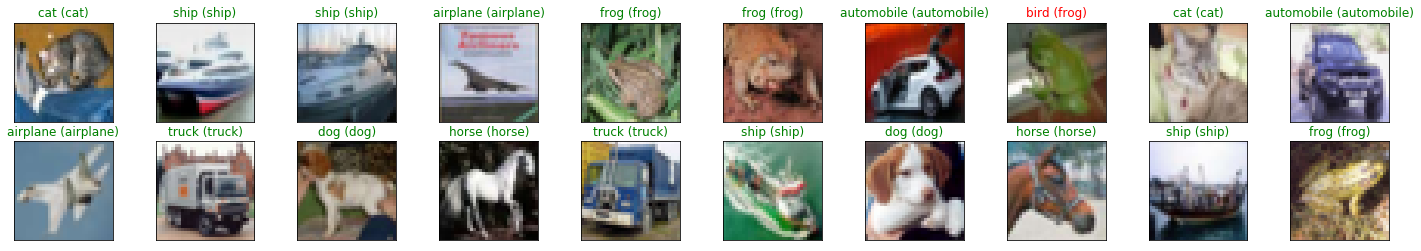

In [21]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) 

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images.cpu()[idx])
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))